In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_Assignment_Image/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_Assignment_Image/Test')

In [4]:
data_dir_train

PosixPath('/content/gdrive/MyDrive/CNN_Assignment_Image/Train')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

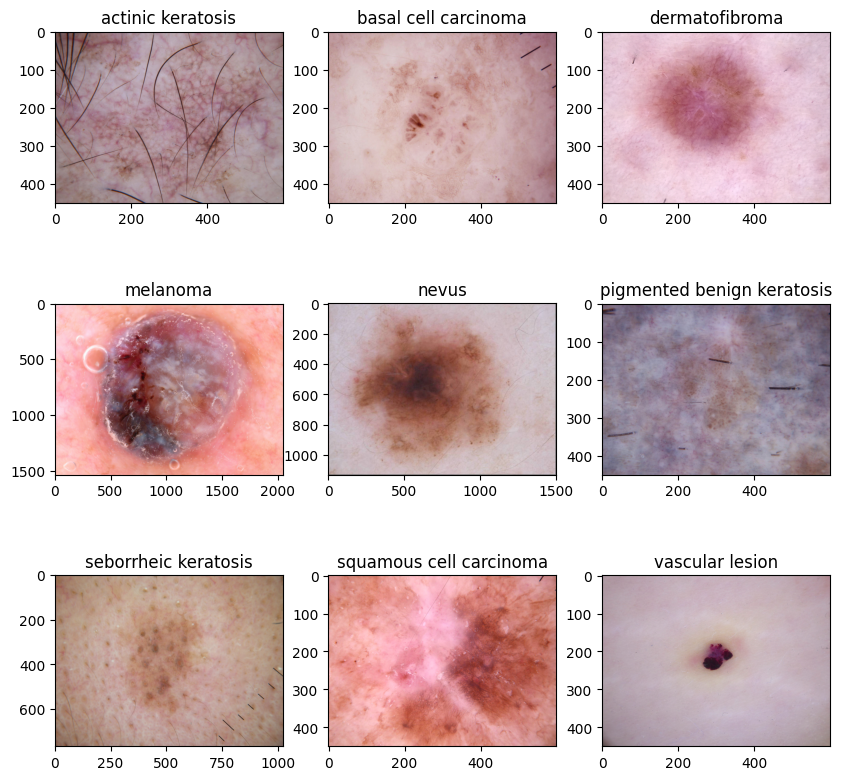

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [15]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 37s 212ms/step - loss: 2.0362 - accuracy: 0.1948 - val_loss: 1.9470 - val_accuracy: 0.2975
Epoch 2/30
56/56 [==============================] - 5s 88ms/step - loss: 1.9733 - accuracy: 0.2478 - val_loss: 1.8815 - val_accuracy: 0.2886
Epoch 3/30
56/56 [==============================] - 5s 90ms/step - loss: 1.8450 - accuracy: 0.3064 - val_loss: 1.7861 - val_accuracy: 0.3512
Epoch 4/30
56/56 [==============================] - 5s 88ms/step - loss: 1.7369 - accuracy: 0.3605 - val_loss: 1.7411 - val_accuracy: 0.3199
Epoch 5/30
56/56 [==============================] - 5s 89ms/step - loss: 1.6949 - accuracy: 0.3650 - val_loss: 1.6594 - val_accuracy: 0.3781
Epoch 6/30
56/56 [==============================] - 5s 94ms/step - loss: 1.6165 - accuracy: 0.4007 - val_loss: 1.6319 - val_accuracy: 0.3982
Epoch 7/30
56/56 [==============================] - 5s 91ms/step - loss: 1.5397 - accuracy: 0.4408 - val_loss: 1.5377 - val_accuracy: 0.4497
Epoch 8/30
56/56 [====

### Visualizing the results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


**Finding on the first base model**

- The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch

- The accuracy is just around 75-80% because there are enough features to remember the pattern.

- But again, it's too early to comment on the overfitting & underfitting debate


In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

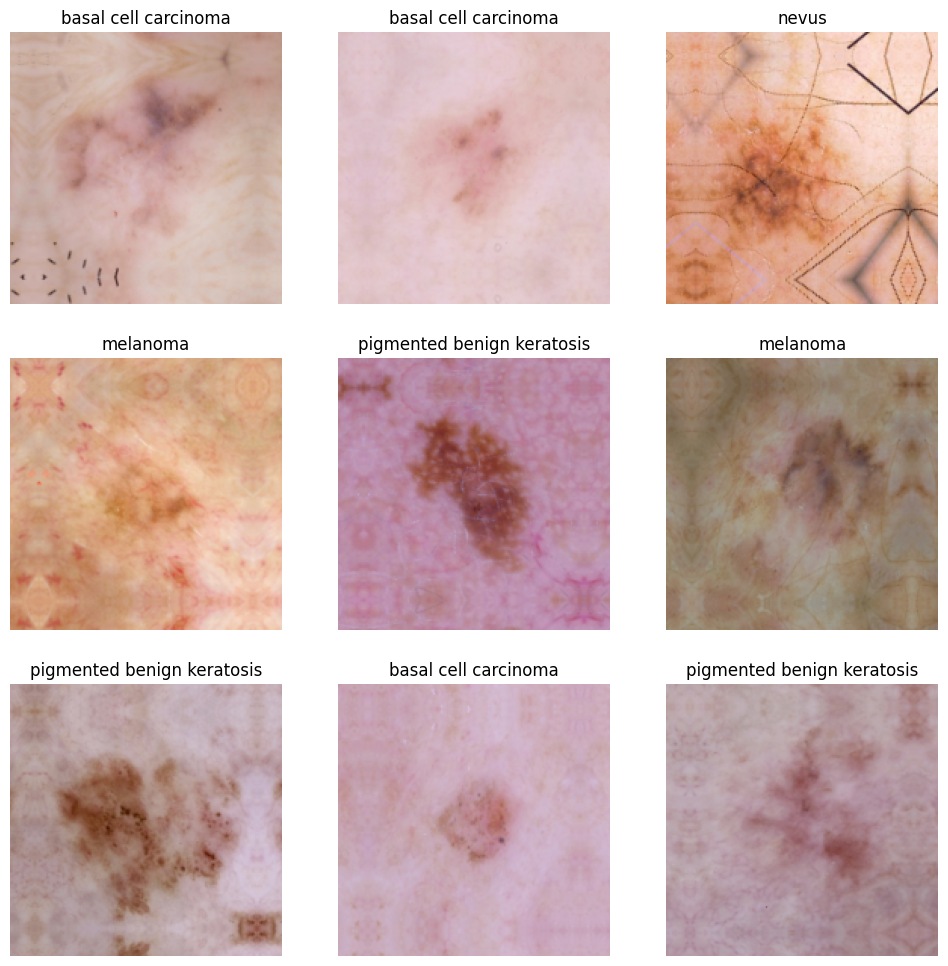

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model

In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compiling the model

In [20]:
### Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 10s 108ms/step - loss: 1.9863 - accuracy: 0.2411 - val_loss: 1.8368 - val_accuracy: 0.3020
Epoch 2/30
56/56 [==============================] - 6s 100ms/step - loss: 1.7287 - accuracy: 0.3711 - val_loss: 1.6538 - val_accuracy: 0.3982
Epoch 3/30
56/56 [==============================] - 6s 99ms/step - loss: 1.6349 - accuracy: 0.3962 - val_loss: 1.5604 - val_accuracy: 0.4452
Epoch 4/30
56/56 [==============================] - 6s 98ms/step - loss: 1.6378 - accuracy: 0.4202 - val_loss: 1.6616 - val_accuracy: 0.3960
Epoch 5/30
56/56 [==============================] - 6s 100ms/step - loss: 1.6386 - accuracy: 0.4029 - val_loss: 1.6013 - val_accuracy: 0.4295
Epoch 6/30
56/56 [==============================] - 5s 98ms/step - loss: 1.6236 - accuracy: 0.4118 - val_loss: 1.6399 - val_accuracy: 0.4161
Epoch 7/30
56/56 [==============================] - 6s 99ms/step - loss: 1.5619 - accuracy: 0.4448 - val_loss: 1.6062 - val_accuracy: 0.4116
Epoch 8/3

### Visualizing the results

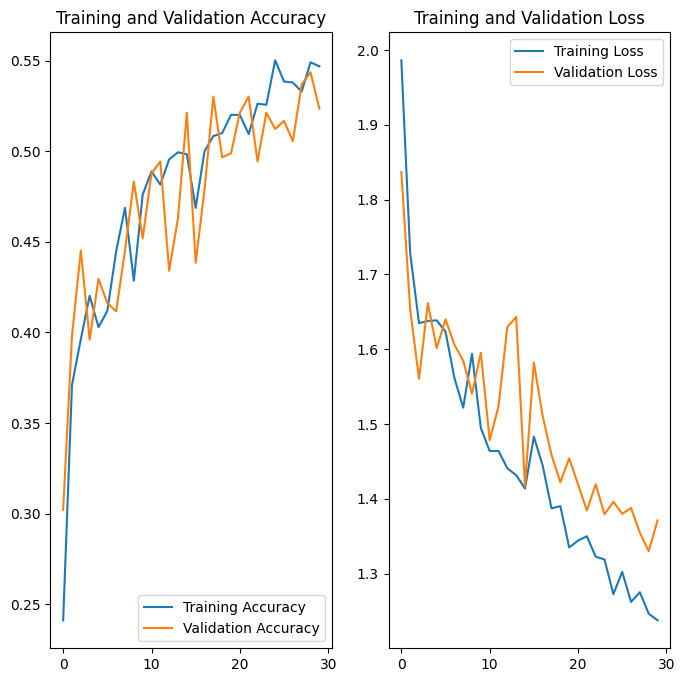

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Finding from Second Model**

- There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation 

- We can increase the epochs to increase the accuracy so it's too early for judgement 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
##
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,actinic keratosis
1,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,actinic keratosis
2,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,actinic keratosis
3,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,actinic keratosis
4,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,vascular lesion
2235,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,vascular lesion
2236,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,vascular lesion
2237,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,vascular lesion


In [24]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,actinic keratosis
1,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,actinic keratosis
2,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,actinic keratosis
3,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,actinic keratosis
4,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,vascular lesion
2235,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,vascular lesion
2236,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,vascular lesion
2237,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,vascular lesion


<BarContainer object of 9 artists>

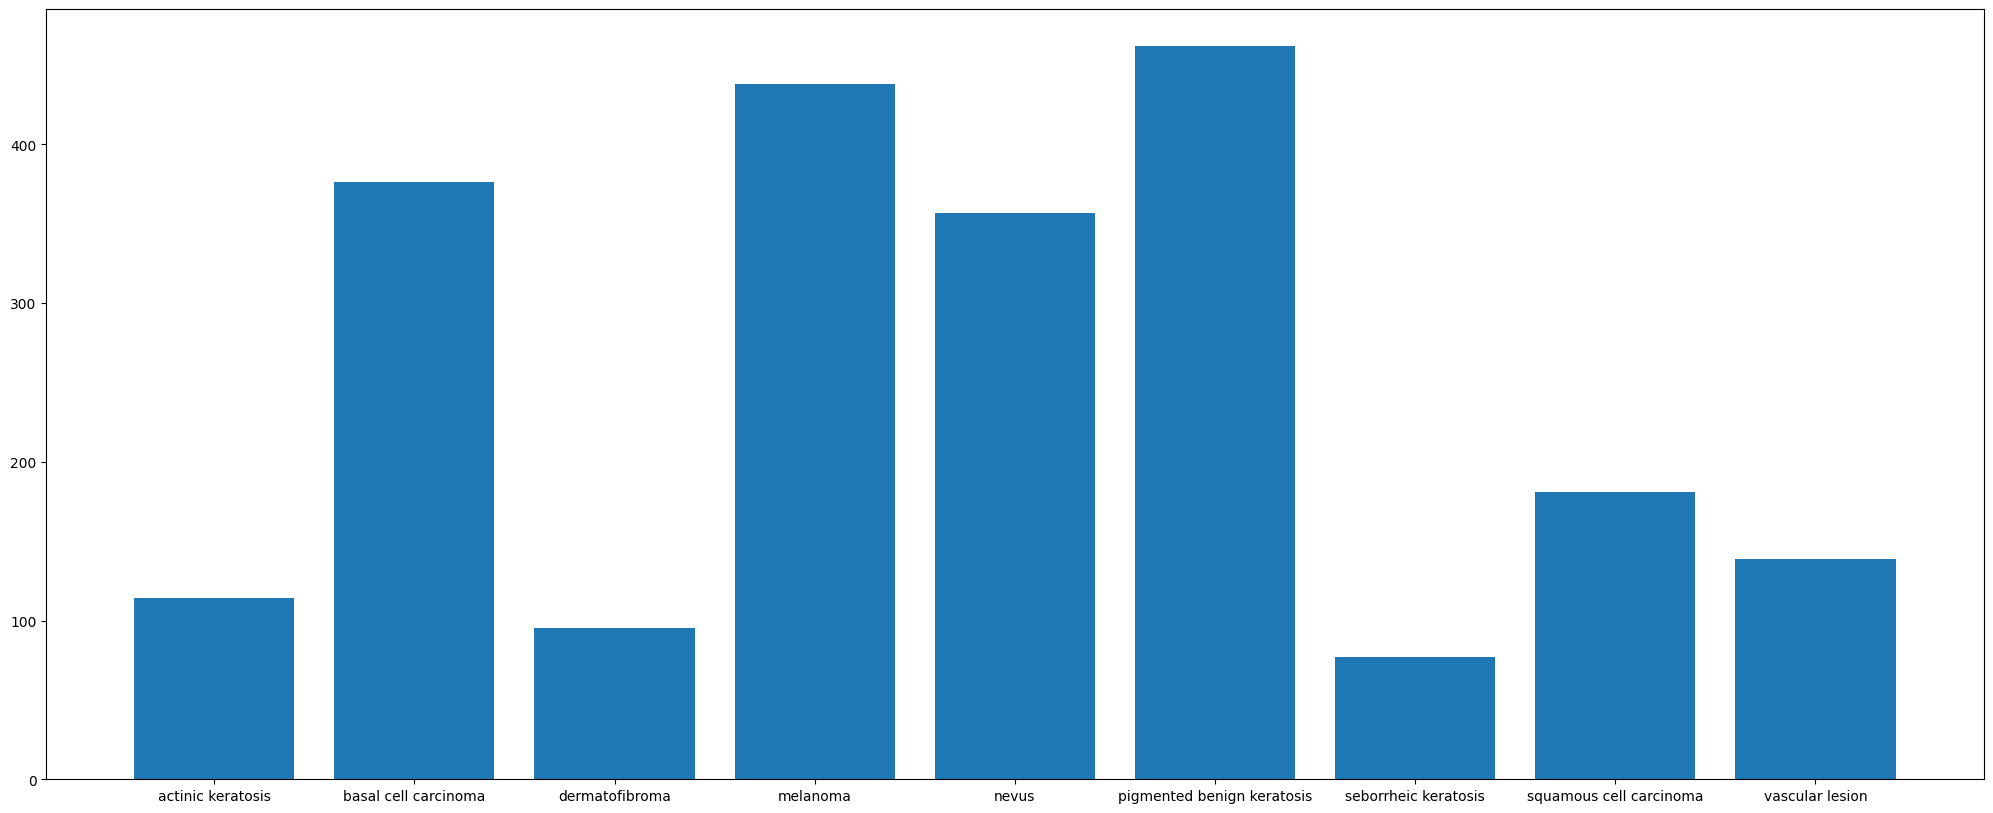

In [25]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

Answer-1 :- **squamous cell carcinoma** has least number of samples

Answer-2:- **actinic keratosis and dermatofibroma** have proportionate number of classes.
**melanoma and pigmented benign keratosis** have proprtionate number of classes

In [26]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [28]:
#path_to_training_dataset="/content/drive/MyDrive/Cancer Detection /Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("/content/gdrive/MyDrive/CNN_Assignment_Image/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment_Image/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA8A4ABEFE0>: 100%|██████████| 500/500 [01:03<00:00,  7.85 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment_Image/Train/output.

Processing <PIL.Image.Image image mode=RGB size=2592x1944 at 0x7FA81A3E7D90>: 100%|██████████| 500/500 [00:48<00:00, 10.24 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment_Image/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA81A3435B0>: 100%|██████████| 500/500 [00:44<00:00, 11.27 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment_Image/Train/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FA81A3AB850>: 100%|██████████| 500/500 [00:50<00:00,  9.85 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment_Image/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA81A1F8BB0>: 100%|██████████| 500/500 [00:53<00:00,  9.34 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment_Image/Train/output.

Processing <PIL.Image.Image image mode=RGB size=966x638 at 0x7FA81A3906D0>: 100%|██████████| 500/500 [00:44<00:00, 11.24 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment_Image/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA8A4973340>: 100%|██████████| 500/500 [00:50<00:00,  9.90 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment_Image/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA81A1F8EE0>: 100%|██████████| 500/500 [00:43<00:00, 11.48 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment_Image/Train/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FA81A3E51B0>: 100%|██████████| 500/500 [00:50<00:00,  9.81 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
data_dir_train1 = pathlib.Path("/content/gdrive/MyDrive/CNN_Assignment_Image/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


In [30]:
##
for i in class_names:
      
    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,actinic keratosis
1,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,actinic keratosis
2,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,actinic keratosis
3,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,actinic keratosis
4,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,actinic keratosis
...,...,...
6734,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,vascular lesion
6735,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,vascular lesion
6736,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,vascular lesion
6737,/content/gdrive/MyDrive/CNN_Assignment_Image/T...,vascular lesion


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
new_df['Label'].value_counts()

pigmented benign keratosis    1398
melanoma                      1313
basal cell carcinoma          1113
nevus                         1070
squamous cell carcinoma        525
vascular lesion                444
actinic keratosis              334
dermatofibroma                 296
seborrheic keratosis           246
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

In [42]:
import pathlib
#data_dir_train1=pathlib.Path("/content/drive/MyDrive/Cancer Detection /Train/output")
data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/CNN_Assignment_Image/Train")

In [43]:
data_dir_train1

PosixPath('/content/gdrive/MyDrive/CNN_Assignment_Image/Train')

#### **Todo:** Create a training dataset

In [44]:
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

2239


In [45]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/CNN_Assignment_Image/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


#### **Todo:** Create a validation dataset

In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [47]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [48]:
## ### Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [49]:
epochs =50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
56/56 [==============================] - 23s 284ms/step - loss: 1.9992 - accuracy: 0.2489 - val_loss: 1.7791 - val_accuracy: 0.3691
Epoch 2/50
56/56 [==============================] - 18s 296ms/step - loss: 1.7179 - accuracy: 0.3890 - val_loss: 1.7181 - val_accuracy: 0.4027
Epoch 3/50
56/56 [==============================] - 19s 289ms/step - loss: 1.6481 - accuracy: 0.4180 - val_loss: 1.7102 - val_accuracy: 0.3848
Epoch 4/50
56/56 [==============================] - 21s 327ms/step - loss: 1.6198 - accuracy: 0.4007 - val_loss: 1.5848 - val_accuracy: 0.4586
Epoch 5/50
56/56 [==============================] - 21s 281ms/step - loss: 1.5287 - accuracy: 0.4637 - val_loss: 1.5542 - val_accuracy: 0.4586
Epoch 6/50
56/56 [==============================] - 18s 287ms/step - loss: 1.5518 - accuracy: 0.4459 - val_loss: 1.5208 - val_accuracy: 0.4810
Epoch 7/50
56/56 [==============================] - 18s 285ms/step - loss: 1.4264 - accuracy: 0.4950 - val_loss: 1.4934 - val_accuracy: 0.4966

#### **Todo:**  Visualize the model results

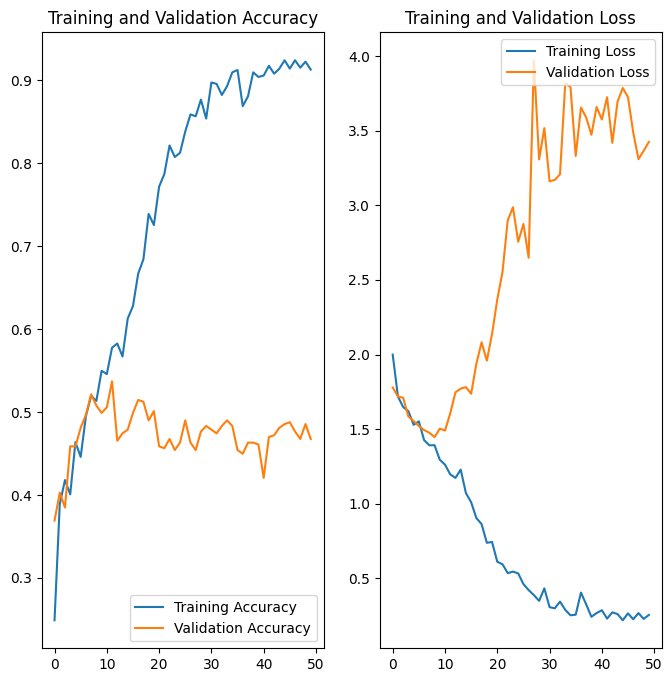

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


- Accuracy on training data has increased by using Augmentor library

- Model is still overfitting

- The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

- The Model can be further improved by tuning the hyperparameter